# An Introduction to Signature Image Cleaning 

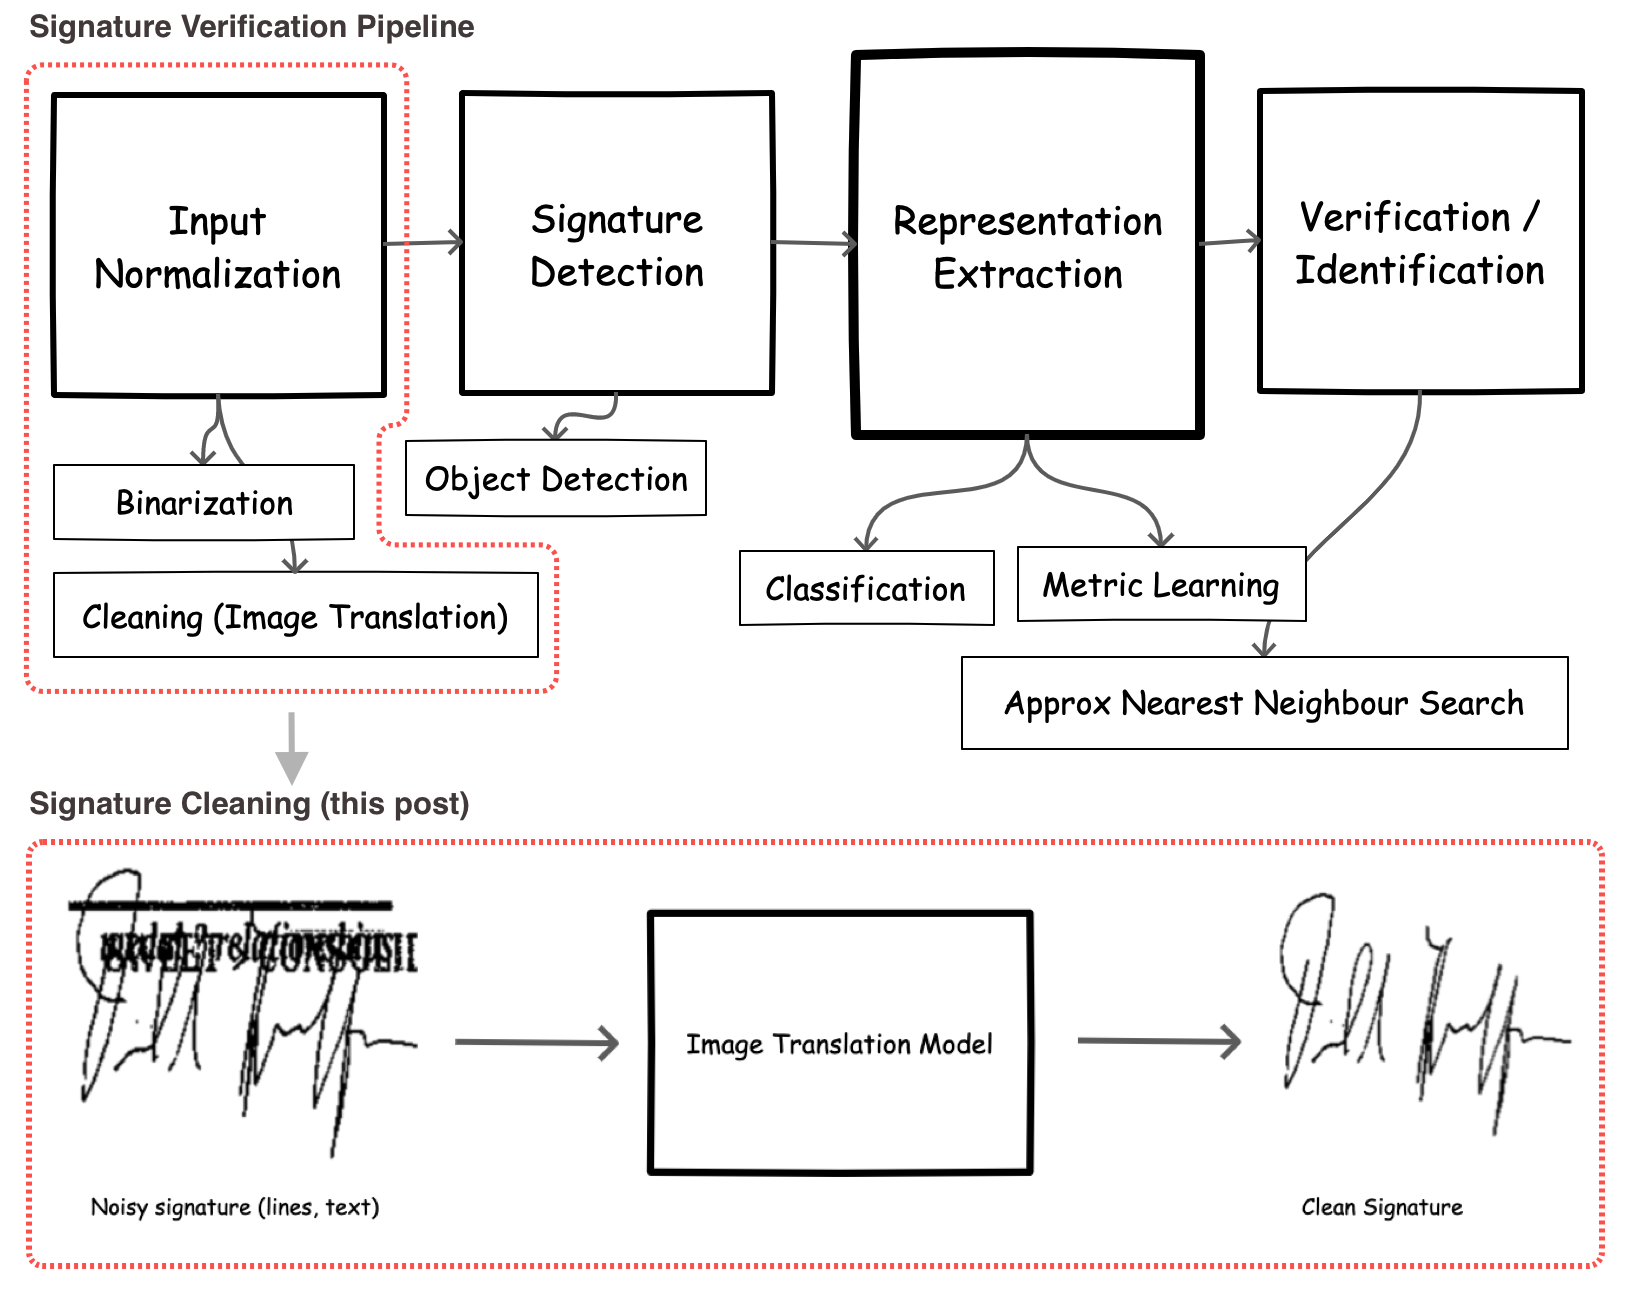

As part of the overall task of signature verification, signature cleaning seeks to automatically remove background noise, text, lines etc that often accompany signatures in the wild. Consider we are building a system for signature verification on signed contracts; we have records for registered users (name, email and atleast one reference document they have signed). Our task is to verify that a new submitted document which claims to be signed by a registered user, was indeed signed by that user. To achieve this goal we need to solve a few problems - first, we need to extract signatures from the submitted document, remove any background noise or artifacts and then compare the cleaned signature to our reference signature on record.  

In this notebook, we will explore how we can the second task - how to implement signature cleaning using an image translation model (a convolutional autoencoder). Here is a list of what you will learn and accomplish:

- **Problem Framing**: Learn how to frame signature image cleaning as a machine learning task and walk through a pros and cons of multiple approaches.
- **Synthetic Data Generator**: Learn how to creatively design a synthetic data generator (simulator) useful for training a model that works well in practice.
- **Data Generator with TF.Data**: Learn how to write a tf.data pipeline that yields batches of samples from your synthetic data generator, for efficient use during model training.
- **Training and Evaluation**: Build, train and evaluate an autoencoder model for signature cleaning that utilizes your tf.data pipeline.



# Problem Framing: Signature Cleaning as Image Translation

We can frame the task of signature cleaning as as an image translation problem where our goal is to learn a transformation from a source domain  (noisy signatures) to a target domain (clean signatures). Two high level appoaches are posible - paired supervised image translation and unpaired image translation. 

---

### Paired Supervised Image Translation

If we have access to pairs of clean + noisy samples, we can apply some model architecture to learn a translation function across these pairs. 

**Candidate Models**:
- Point Estimate Models: Point estimate models learn to model a translation function given an input. A familiar example of models in this category is a denoising autoencoder that learns to remove random noise from images. Other related models include a [Unet](https://github.com/MrGiovanni/UNetPlusPlus) model (learns to output cleaned image instead of segmentation mask) and U2Net models.
- Generative Models: Generative models aim to model the distribution of the target domain (conditioned on some input). A classic example is a Variational Autoencoder or a conditional GAN. Both approaches learn the target distribution from which we can draw samples conditioned on a source domain input. 
This approach can be particularly valuable if our goal is to generate new unseen samples clean signature. In practice, these models are morecomplicated to implement, sometimes yield fuzzy or unrealistic results and or include unexpected artifacts.  Pix2PixGAN 

Perhaps the biggest challenge to a paired supervised image translation approach is that we need example aligned pairs of the source and target domain for training. This can be very expensive to curate and acquire.


### Unpaired Image Translation
This explores the use of unpaired examples to learn a mapping from clean to noisy.  It assumes we have access to a large dataset of the source domain (noisy images), and a separate large datasets of the target domain (clean images). 
This method requires less data curation effort, but may not result in high quality translations (this is mainly because there is no explicit supervisory signal, making the problem underconstrained).

**Candidate Models:**
- CycleGAN is perhaps a classic example. It helps address the under constrained problem by introducing a cycle consistency loss.

 

---
## Which to Use?
An unpaired strategy holds promise i.e., it is relatively easier to assemble a large unlabelled set of images from source and target domains than to manually curate paired examples. However, the unpaired problem is underconstrained, and can suffer several known problems of GANs.[limitations](https://prinsphield.github.io/posts/2017/07/math_view_cyclegan/). Existing [work](https://arxiv.org/pdf/1905.09000.pdf) also indicate that a paired approach can result in better translation results (they show how a UNet based autoencoder is 2.2x faster than a CycleGAN approach and achieves better SSIM (4 points) and MSE values). 

In our use case, we have some idea on the space of noise we want to remove and can explore a synthetic data generation process. E.g. we know that the kind of noise we are likely to see in live signature docs are mostly lines, dates, titles, names, salt and pepper noise etc. We can write a simulator that takes genuine real world signatures and _randomly_ generates noisy pairs that juxtapose all of the noise artifacts we care about. Overall, it takes less effort to create this simulator compared to manually curating a clean vs noisy set.


A summary on pros and cons of both approaches:

### Unpaired Translation 
- Pros:
  - Will benefit from the availability of large source (noisy) and target (clean) datasets
  - Will naturally learn a diverse set of edge cases from large corpora
- Cons
  - There will likely be artifacts in the resulting clean images (due to limitations of unpaired image translation methods)
  - Can be challenging to improve/control the resulting model to address any identified failure cases.

### Paired Translations via Simulations
- Pros:
  - Will work very well for covered edge cases. If the translation space is well defined and can be represented by rules in a simulator, this solution is sufficient.
  - Can support rapid iterations and offline evaluation of multiple model architectures
  - Simulator rules can be continuously updated to additional test cases as they are discovered
  - We can generate 'infinite' training samples and train a model until convergence (i.e., it learns to solve the task given the examples generated) 
- Cons
  - Simulator needs to be comprehensive and cover all edge cases
  - Will not readily generalize to unseen cases. Perhaps a generative model is more useful here?
  - Evaluating on simulator test cases does not tell us about the real world. We need to still design a test harness that efficiently helps us identify failure cases. Using this information, the simulator needs to be constantly updated to reduce any differences between the online distribution of noisy signatures and offline noisy signatures which the simulator generates.
  

In this work, we will take a paired data simulation approach. We will use the [CEDAR](https://cedar.buffalo.edu/signature/) dataset as our source of "genuine" images and create a simulator to generate noisy samples based on these samples.

In [ ]:
import os
import requests
import sys
import random
import itertools
from typing import Tuple
from PIL import Image, ImageDraw, ImageFont

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn 
warnings.filterwarnings("ignore", category=UserWarning)

from scipy.spatial.distance import cosine, euclidean, cdist
import tensorflow 

import PIL
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers  
# %load_ext nb_black
from tqdm.notebook import tqdm 
  
from skimage.filters import try_all_threshold, threshold_otsu
from tensorflow.keras.applications import resnet, EfficientNetB0
from sklearn.metrics import roc_curve

tf.random.set_seed(2018) 
np.random.RandomState(2018)
random.seed(2018) 

CEDAR_PATH = "../input/cedardataset/signatures" 
!rm -rf traindata td
!mkdir -p traindata/train/train
!mkdir -p traindata/val/val
!mkdir models

In [ ]:
# Utility Functions

def threshold_image(img_arr):
  thresh = threshold_otsu(img_arr)
  return np.where(img_arr > thresh, 255, 0)

def load_img_np(img_path, resize=False):
  img_np = load_img(img_path)
  if resize:
    img_np = load_img(img_path, target_size=img_target_size)
  img_np = np.squeeze(img_to_array(img_np))  
  img_np = threshold_image(img_np)  
  return img_np

def visualize_predictions(model, val_ds):
  # get a batch of validation examples
  (test_aug, test_clean) = next(iter(val_ds)) 
  predicted_test = model.predict(test_aug)
  plt.figure(figsize=(18, 10))
  for aug, clean in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      clean_aug = np.concatenate((test_aug[i].numpy() ,predicted_test[i], test_clean[i].numpy() ), axis =1)
      plt.imshow(clean_aug)
      plt.axvline(x=224, color='g', label='axvline - full height')
      plt.axvline(x=448, color='g', label='axvline - full height')
      plt.title("   Noisy Input | Prediction | Ground Truth ") 
      plt.axis("off")


def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False)

def SSIM(y_true, y_pred): 
  # betweeen 0 and 1. Higher the better
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def PSNR(y_true, y_pred): 
    # should be between 30 and 50. Higher the better
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
    
def plot_vals(ax,history, metric_title, model_name):
  ax.plot(history.history[metric_title])
  ax.plot(history.history['val_' + metric_title])
  ax.set_title(model_name + ' | ' + metric_title + " | " + str(round(history.history['val_' + metric_title][-1],2)) )
  ax.set_ylabel(metric_title.upper())
  ax.set_xlabel('Epoch')
  ax.legend(['Train', 'Test'], loc='upper left')

def plot_history(history, title=""):  
  fig, axes = plt.subplots(2,2, figsize=(12,10))
  metric_list = ["loss","rmse","PSNR","SSIM"]

  for i, ax in enumerate(axes.flatten()): 
    plot_vals(ax, history, metric_list[i], title) 

  plt.tight_layout()
  plt.show()

# Designing a Synthetic Paired Data Generator Function

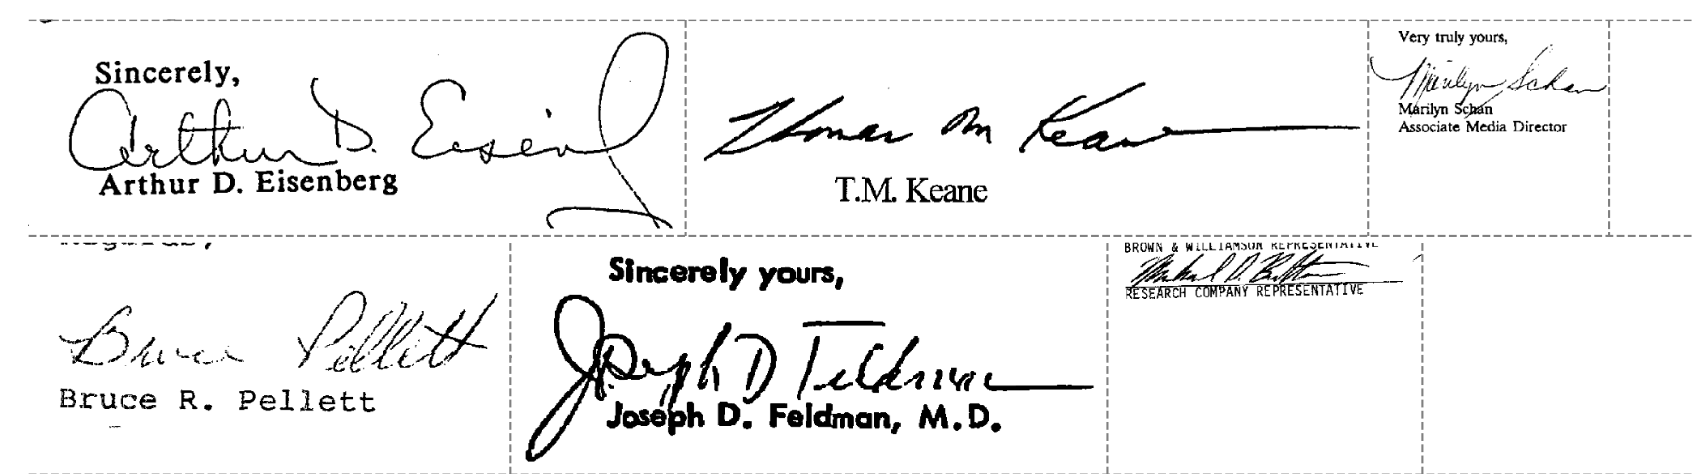

For this usecase, I have studied a variety of example signatures in the wild (see examples in the image above, sourced from the [SignverOD](https://www.kaggle.com/victordibia/signverod) dataset) and assembled the following set of rules to build the synthetic data generator:

## Initial Rules

For each image, explore the following augmentations to produce a "noisy" version.

- Add lines 
  - Randomly select one of 3 different offsets - top, middle and bottom
  - add slight slants to line
  - Add multiple lines of varied width
- Add text
  - Randomly select one of 9 fonts
  - Randomly select words from [MIT wordnet](https://www.mit.edu/~ecprice/wordlist.10000). Also add some _primary_ words (e.g., yours sincerely) known to frequently occur as background text around signatures to increase the model's probability of removing those words. Also add random punctuations
  - Place text at random height locations.
- Add salt and pepper noise to mirror signature thresholding and real world document scanning artifacts. This (as well as all of the other steps) turn out to be important for generalization!
 

## Iterating on the Simulator After Reviewing Online Evaluations
Some updates to the simulator that were implemented after reviewing failure modes when tested online with signatures extracted from scanned documents in the wild. 

- Increase line thickness ranges
- Add vertical lines to arbitraty y locations
- Compress/resize text to mirror live aspect rations. i.e., add text to original image and then resize 
- Add more bold and italics text (earlier version did not priotitize this, leading to a model that did not remove bold text)
- Apply thresholding after the noise + text addition, not before. At test time, the model sees a thresholded image where there are no low intensity pixel. Thats makes for a significantly different distribution.
- Text aspect ratio: Neural nets typically require a fixed sized input, meaning signatures are resized to a square aspect ratio before being fed into a neural network. This aspect ration has to be mirrored by the simulator - i.e., the entire noisy image is resized _after_ adding text.
 

In [ ]:
# download a set of fonts for use in the simulator
!rm -rf fonts
!git clone https://github.com/victordibia/fonts 
    
# download a list of words for use as background text     
word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
response = requests.get(word_site)
words = [x.decode() for x in response.content.splitlines()]

# list of font types to exclude
font_list = []
excluded_font_types = ["Light", "Medium"]  # ["Bold","Italic", "Light", "Medium"]

def is_font_valid(font): 
  for val in excluded_font_types:
    if val.lower() in font.lower():
      return False
  return True

for path, subdirs, files in os.walk("fonts/fonts"):
    for name in files:
        font_path = os.path.join(path, name)
        if (is_font_valid(font_path) and font_path.split(".")[1] == "ttf"):
          font_list.append(font_path)                 

In [ ]:
from random import randint
import string 

# Some words like more likely to be found around a signature - names, honorifics, prefixes, suffixes, titles. 
# Perhaps we can get the data generator to always add them such that the model gets really good at discovering and removing those words 
primary_words = ["Board of Trustees", "Trustee", "Meeting", "Board", "Best Wishes", "Wishes", "Best", "Yours Truly ", "Yours" , "Sincerely", "Best Wishes", "President", "Chairman", "Phd"]


def get_pil_font(): 
  # Randomly select a font from a list of common fonts  
  font_path = font_list[randint(0,len(font_list) -1)] 
  try:
      font = ImageFont.truetype(font_path, random.randint(25,55))
  except IOError:
      font = ImageFont.load_default()
  return font

def get_word(add_primary=False): 
  # based on probabilities, get a single or double word, which may be lower or upper or capitalize case.
  word = words[random.randint(0, len(words)-1)] 
  if random.random() > 0.7:
    word = word + " " + primary_words[random.randint(0, len(primary_words)-1)]

  prob = random.random()
  if prob < 0.25:
    return word.lower()
  if prob > 0.25 and prob <  0.75:
    return word.upper()
  if prob > 0.75:
    return word.capitalize()

def get_text():
  # get augmentation text as random punctuations + words
  punctuations = string.punctuation 
  text =  get_word() + " " + punctuations[random.randint(0, len(punctuations) -1)] + " " + get_word()    
  if random.random() > 0.5:
    text = text + " " + get_word()
  return text

def draw_line(img_size=(224,224)):
  img = Image.new('L', img_size, color = (255))
  draw = ImageDraw.Draw(img)
  im_width, im_height = img_size 
  
  # draw two random words from the MIT wordlist  
  text = get_text() 

  # randomly place horizontal line  in one of three locations
  y_pos_list = [im_height*0.2, im_height*0.5, im_height*0.8]
  y_pos = y_pos_list[random.randint(0, len(y_pos_list)-1)]

  line_shape = [( random.randint(0,80) ,y_pos ), (im_width - random.randint(0,80), y_pos  )]
  # line_shape = [( 0,y_pos ), (im_width , y_pos  )]
  draw.line(line_shape, fill="black", width=random.randint(1,9))

  # draw a shorter line segment
  hy_pos = random.randint(80, im_height)
  half_line_shape = [(random.randint(int( im_width *0.25), im_width) ,hy_pos ), (random.randint(int( im_width *0.25), im_width) , hy_pos  )]
  draw.line(half_line_shape, fill="black", width=random.randint(1,9))

  mask = Image.fromarray(np.uint8(255*(np.random.rand(im_height,im_width ) > random.uniform(0.75, 1))))
  draw.text((random.randint(50,170), y_pos + random.randint(2,20)), text, fill="black", font=get_pil_font()) 
  img.paste(mask,(0,0), mask) 

  return img 

def draw_text(img_size=(224,224), font_size=30):
  #draw words from MIT wordlist
  text = get_text()

  im_width, im_height = img_size
  img = Image.new('L', img_size, color = (255))
  draw = ImageDraw.Draw(img)

  # randomly place text at one of three x,y locations
  y_pos_list = [im_height*0.2, im_height*0.5, im_height*0.8]
  y_pos = y_pos_list[random.randint(0, len(y_pos_list)-1)]


  x_pos_list = [0, im_width*0.1, im_width*0.2]
  x_pos = x_pos_list[random.randint(0, len(x_pos_list)-1)]

  draw.text((x_pos,y_pos), text, fill="black", font=get_pil_font()) 

  mask = Image.fromarray(np.uint8(255*(np.random.rand(im_height,im_width) > random.uniform(0.98, 1))))  
  return img
 

def get_aug(img_paths, img_target_size=(224, 224)):
  # for each image in img_paths, load image, generate noisy version, return both clean and noisy version
  aug_holder = []
  clean_holder = []
  
  for img_path in img_paths: 
    img_np =  load_img_np(img_path)

    # img_np = threshold_image(img_np)   
    image = Image.fromarray(np.uint8(img_np)).convert('RGB') 
    clean_image = image.resize((img_target_size))
    clean_holder.append( threshold_image(np.array(clean_image)) * (1./255))  
    im_width, im_height = image.size  
    bg = draw_line(img_size=image.size) 

    # randomly add  text 
    if random.random() > 0.5:
      bg.paste(draw_text(img_size=image.size), (0,0), bg)

    # randomly add another text 
    if random.random() > 0.5:
      bg.paste(draw_text(img_size=image.size), (0,0), bg) 
    
    img_mask = image.convert('L') 
    image.paste(bg,(0,0), img_mask)

    # resize image to target size
    image = (image.resize((img_target_size))) 
    aug_holder.append( threshold_image(np.array(image)) * (1./255)) 

  return np.array(clean_holder), np.array(aug_holder)

In [ ]:
img_paths = [f"{CEDAR_PATH}/full_forg/forgeries_10_1.png",f"{CEDAR_PATH}/full_forg/forgeries_10_2.png"] 
clean, auggy = get_aug(img_paths)
plt.figure(figsize = (20,6))
plt.axis('off')
plt.imshow(np.concatenate((auggy[0],clean[0]), axis=1) );
plt.axvline(x=224, color='g', label='axvline - full height');

# Create a TF Dataset Loader that Uses The Generator Function

## Addressing Potential Data Leakage in Constructing Train/Validation Sets

In the CEDAR dataset, there are signatures and forgeries of the same signer ... if we dont do a train/val split based on signatures or signers, there is a chance that the model sees the same structures in train and test which might cause it to "memorize" these structures and fail to perform as well on completely new datasets. 
- Model learns to clean well for types of signers in dataset
- Since evaluation set has those same signatures, the model might use that infromation and show performance _above_ what we would see in completely new datasets.

We select the ids of 10 signers (out of 55 signers), move their signatures and forgeries to a different folder 

In [ ]:
holdout_signers = [2,5,15,6,19,22,51,34,48,30] 
holdout_names = ["original_" + str(x) + "_" for x in holdout_signers] + [ "forgeries_" + str(x) + "_" for x in holdout_signers]
print(f"We hold out genuine/forgeries associated with  {len(holdout_signers)} signers.")

In [ ]:
all_images = []
for path, subdirs, files in os.walk(CEDAR_PATH):
    for name in files:
        image_path = os.path.join(path, name)
        if "png" in image_path:
          all_images.append(image_path)   

train_images = []
val_images = []

def is_holdout(img_path):
  for name in holdout_names:
    if name in img_path:
      return True 
  return False

for img in tqdm(all_images):
  if is_holdout(img):
    val_images.append(img) 
  else:
    train_images.append(img) 

print(f"Processed {len(all_images)} images | {len(train_images)} train ; {len(val_images)} validation" )

## Create tf.Data Dataset from Tensor Slices

- Create train and validation set using list of train and validation images
- Apply a mapping function using tf.py_function that calls our paired data generator function

In [ ]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_images)).shuffle(5, seed=123).repeat(3).batch(batch_size) 
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_images)).batch(batch_size) 

def generate_pair(x):  
  clean, aug = get_aug(x.numpy()) 
  return (aug, clean)

train_ds = train_ds.map(lambda x, y: tf.py_function(generate_pair, [x], [tf.float32,tf.float32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(generate_pair, [x], [tf.float32,tf.float32])) 

# Visualize Data from Our tf.Data Pipeline

It is always a good idea to carefully visualize and review example data generated by our tf.data pipeline. Below we take a single batch from our pipelie and visualize pairs of noisy and clean images. Note that each time a sample is drawn, a random augmentation is applied.

In [ ]:
plt.figure(figsize=(16, 10))
for aug, clean in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    clean_aug = np.concatenate((aug[i].numpy(), clean[i].numpy() ), axis =1)
    plt.imshow(clean_aug)
    plt.axvline(x=224, color='g', label='axvline - full height')
    plt.title("Noisy Augmented    |   Clean         . ")
    plt.axis("off")

In [ ]:
# we can use caching and prefetching to improve performance 
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Training a Convolutional Autoencoder Model 

We implement a simple convolutional autoencoder model using 3 conv2D layers in the encoder and decoder. As a quick refresher, an autoencoder learns to map some input data to a lower dimension and then reconstruct the input from this lower dimension representation. In this case our goal is to reconstruct a "cleaned" version of the input, given the low dimension. We will add Dropout layers to reduce the chance of our model [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).
    
    
## Model Evaluation - Image Similarity Metrics

To evaluate our model, we can leverage metrics for image quality assessment. That is, we want to assess the quality of a target (cleaned image), given some ground truth reference. In this example, we will explore 3 metrics for this task 

- Root Mean Squared Error ([RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)). Implemented using [tf.image.psnr](https://www.tensorflow.org/api_docs/python/tf/image/psnr). Implemented using [tf.keras.metrics.RootMeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)
- Peak Signal to Noise Ration ([PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio))  
- Structural Similarity index ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity)). Implemented using [tf.image.ssim](https://www.tensorflow.org/api_docs/python/tf/image/ssim)

In [ ]:
def get_autoencoder(input_shape=(224,224,3), num_layers = 4, num_filters = 64): 
    
  input = layers.Input(shape=input_shape)
  x = input
  
  # Encoder
  for i in range(num_layers): 
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x) 
    num_filters = num_filters * 2
  
  x = layers.Dropout(0.2)(x)
  
  # Decoder
  for i in range(num_layers): 
    num_filters = num_filters /2
    x = layers.Conv2DTranspose(num_filters, (3, 3), strides=2, activation="relu", padding="same")(x) 
     
  x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x) 
  # Autoencoder
  autoencoder = Model(input, x, name="autoencoder")

  initial_learning_rate = 0.004
  # tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.80,
    staircase=False)
  
  autoencoder.compile(optimizer="adam", loss="binary_crossentropy",metrics=[PSNR, tf.keras.metrics.RootMeanSquaredError(name="rmse"), SSIM])
  return autoencoder

In [ ]:
ae = get_autoencoder(num_layers=3)
ae.summary() 

In [ ]:
def train_autoencoder(ae, epochs=4):
  history = ae.fit(
      train_ds,
      epochs=epochs, 
      validation_data=val_ds,
  ) 
  plot_history(history, title="Convolutional Autoecoder")
train_autoencoder(ae,epochs=10)

# Visualize Predictions

In [ ]:
visualize_predictions(ae, val_ds)

In [ ]:
def save_model(name, model):
  print(">>> Saving model", name) 
  model_dir = "models/"+name
  tf.keras.models.save_model(model, model_dir, save_traces=True, include_optimizer=False)

save_model("autoencoder", ae)

## Conclusion

In this notebook, we looked at approaches for cleaning images, how to generated paired data samples for this task and implemented an autoencoder which achieved 0.94 SSIM score (max of 1). The autoencoder does succeed at removing non-trivial noise and background in signatures (see examples in the visualize predictions section above ). 


## Next Steps / Extra Credit


- Extend the base autoencoder model. Hint (try increasing the number of layers)
- Try out additional models architectures e.g., Unet. UNet-like models with residual connections learn low level multiscale features that can be useful for a task like noise artifact removal. Hint: experiment with a vanilla Unet, see reference implementation by [Karol Zak](https://github.com/karolzak/keras-unet/blob/master/keras_unet/models/vanilla_unet.py). Also, what happens if we initialize our model using pretrained imagenet model weights? 
- Extend the data generator to include new edge cases
- Explore offline evaluations on a set of noisy signatures extracted from signatures in the wild. Hint: Use the [signver library](https://github.com/victordibia/signver) to extract noisy signatures from documents and apply your model in cleaning them.
- Cleaning signatures is just one step in the signature verification process, other tasks such as signature detection, and representation extraction can benefit from deep learning models. Hint: see this [blog post](https://blog.fastforwardlabs.com/2021/05/26/deep-learning-for-automatic-offline-signature-verification-an-introduction.html) for more info. 


# References

- The [CEDAR dataset](https://cedar.buffalo.edu/signature/) is used in this work. 
- Learn more about model overfitting and why we use Dropout layers in the autoencoder model. [Model Overfit and Underfit, Tensorflow.org](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
- Implementation of metrics -  [PSNR - tf.image here](https://www.tensorflow.org/api_docs/python/tf/image/psnr), [SSIM - tf.image here](https://www.tensorflow.org/api_docs/python/tf/image/ssim), [RMSE - tf.keras.metrics.RootMeanSquaredError ](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)
- Want to learn more about other tasks in the signature verification pipeline? I have written an introductory blog post on the subject here - [blog post](https://blog.fastforwardlabs.com/2021/05/26/deep-learning-for-automatic-offline-signature-verification-an-introduction.html).
